[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/porterjenkins/byu-cs474/blob/master/lab5_generalization.ipynb)

# Lab 5: Measuring Performance

## Objectives


*   Understand how to accurately measure generalization performance of deep networks
*   Gain intuition into the bias-variance trade-off and the double descent phenomenon
*   Investigate properties of high dimensional spaces and better understand the ''curse of dimensionality''



## Deliverable

You will turn in a completed version of notebook to Canvas/Learning Suite.  In various places you will see the words "TO DO". Follow the instructions at these places and write code to complete the instructions



## Notes
You will not need a GPU instance for this lab

## Q1) Understanding Generalization

In this question, we will use the MNIST1D dataset (https://github.com/greydanus/mnist1d) to reproduce Figure 8.2 from Prince.

In [1]:
# Run this if you're in a Colab to install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-1orek000
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-1orek000
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code. The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [3]:
!mkdir ./sample_data

args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./sample_data/mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

mkdir: cannot create directory ‘./sample_data’: File exists
Successfully loaded data from ./sample_data/mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [4]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions

### Part 1.a)

**TODO:** Define a PyTorch model with two hidden layers of size 100 And ReLU activations between them

In [5]:
class NeuralNet(nn.Module):
    def __init__(self, D_i=40, D_k=100, D_o=10):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(D_i, D_k)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(D_k, D_k)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(D_k, D_o)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
model = NeuralNet(D_i, D_k, D_o)

**TODO:** Initialize the parameters with He initialization

In [6]:
def weights_init(layer_in):
    if isinstance(layer_in, nn.Linear):
        nn.init.kaiming_normal_(layer_in.weight, mode='fan_in', nonlinearity='relu')
        if layer_in.bias is not None:
            nn.init.zeros_(layer_in.bias)

In [7]:
# Call the function you just defined
model.apply(weights_init)

NeuralNet(
  (layer1): Linear(in_features=40, out_features=100, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (output_layer): Linear(in_features=100, out_features=10, bias=True)
)

In [8]:
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('long'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)


NeuralNet(
  (layer1): Linear(in_features=40, out_features=100, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (output_layer): Linear(in_features=100, out_features=10, bias=True)
)

In [9]:
def train_model(model, data_loader, n_epoch=50):

    # Initialize model weights
    model.apply(weights_init)

    # store the loss and the % correct at each epoch
    losses_train = np.zeros((n_epoch))
    errors_train = np.zeros((n_epoch))
    losses_test = np.zeros((n_epoch))
    errors_test = np.zeros((n_epoch))

    # choose cross entropy loss function (equation 5.24)
    loss_function = torch.nn.CrossEntropyLoss()
    # construct SGD optimizer and initialize learning rate and momentum
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
    # object that decreases learning rate by half every 10 epochs
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)


    for epoch in range(n_epoch):
      # loop over batches
      for i, batch in enumerate(data_loader):
        # retrieve inputs and labels for this batch
        x_batch, y_batch = batch
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass -- calculate model output
        pred = model(x_batch)
        # compute the loss
        loss = loss_function(pred, y_batch)
        # backward pass
        loss.backward()
        # SGD update
        optimizer.step()

      # Run whole dataset to get statistics -- normally wouldn't do this
      pred_train = model(x_train)
      pred_test = model(x_test)
      _, predicted_train_class = torch.max(pred_train.data, 1)
      _, predicted_test_class = torch.max(pred_test.data, 1)
      errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
      errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
      losses_train[epoch] = loss_function(pred_train, y_train).item()
      losses_test[epoch]= loss_function(pred_test, y_test).item()
      print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

      # tell scheduler to consider updating learning rate
      scheduler.step()

    return errors_train, errors_test, losses_train, losses_test

In [10]:
def plot_results(errors_train, errors_test, losses_train, losses_test, n_epoch=50):

    # Plot the results
    fig, ax = plt.subplots()
    ax.plot(errors_train,'r-',label='train')
    ax.plot(errors_test,'b-',label='test')
    ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
    ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
    ax.legend()
    plt.show()

    # Plot the results
    fig, ax = plt.subplots()
    ax.plot(losses_train,'r-',label='train')
    ax.plot(losses_test,'b-',label='test')
    ax.set_xlim(0,n_epoch)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
    ax.legend()
    plt.show()

**TODO:** Train your model for 50 epochs

In [11]:
errors_train, errors_test, losses_train, losses_test = train_model(model, data_loader, n_epoch=50)

Epoch     0, train loss 1.584075, train error 63.38,  test loss 1.654143, test error 69.00
Epoch     1, train loss 1.310407, train error 47.78,  test loss 1.425384, test error 54.30
Epoch     2, train loss 1.143442, train error 40.42,  test loss 1.333532, test error 50.70
Epoch     3, train loss 0.972239, train error 34.10,  test loss 1.215567, test error 47.20
Epoch     4, train loss 0.857457, train error 30.12,  test loss 1.171715, test error 47.10
Epoch     5, train loss 0.797841, train error 27.75,  test loss 1.157515, test error 44.00
Epoch     6, train loss 0.687979, train error 23.07,  test loss 1.131054, test error 43.50
Epoch     7, train loss 0.619596, train error 21.53,  test loss 1.102749, test error 40.80
Epoch     8, train loss 0.577661, train error 20.72,  test loss 1.108875, test error 41.10
Epoch     9, train loss 0.516129, train error 17.80,  test loss 1.091481, test error 40.60
Epoch    10, train loss 0.407050, train error 11.97,  test loss 1.095850, test error 40.70

**TODO**: Plot the resulting quantities:
- Train errors
- Test errors
- Train losses
- Test losses

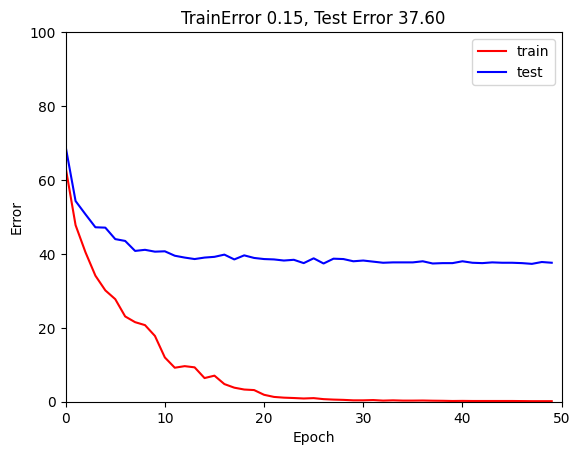

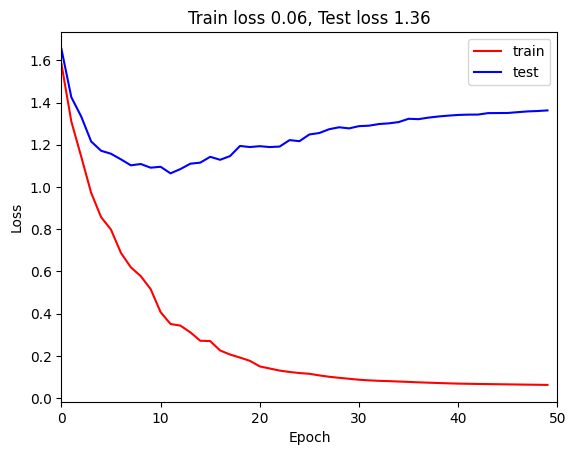

In [12]:
plot_results(errors_train, errors_test, losses_train, losses_test, n_epoch=50)

### Part 1.b)

Now let's increase the capacity of our model to have five hidden layers and re-run our experiment. Pay attention to what happens to the train and test curves.

**TODO:**
Define a model with five hidden layers of size 100
and ReLU activations between them

In [13]:
# Define the model with five hidden layers of size 100 and ReLU activations
class NeuralNetFiveLayers(nn.Module):
    def __init__(self, D_i=40, D_k=100, D_o=10):
        super(NeuralNetFiveLayers, self).__init__()
        self.layer1 = nn.Linear(D_i, D_k)
        self.layer2 = nn.Linear(D_k, D_k)
        self.layer3 = nn.Linear(D_k, D_k)
        self.layer4 = nn.Linear(D_k, D_k)
        self.layer5 = nn.Linear(D_k, D_k)
        self.output_layer = nn.Linear(D_k, D_o)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
model_five_layers = NeuralNetFiveLayers(D_i, D_k, D_o)

# Initialize model weights using He initialization
model_five_layers.apply(weights_init)

NeuralNetFiveLayers(
  (layer1): Linear(in_features=40, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=100, bias=True)
  (layer5): Linear(in_features=100, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)

**TODO**: Train the model using the same code as above

In [14]:
errors_train, errors_test, losses_train, losses_test = train_model(model_five_layers, data_loader, n_epoch=50)

Epoch     0, train loss 1.750167, train error 69.93,  test loss 1.792495, test error 72.00
Epoch     1, train loss 1.438396, train error 56.42,  test loss 1.530552, test error 63.20
Epoch     2, train loss 1.209983, train error 46.78,  test loss 1.403236, test error 56.00
Epoch     3, train loss 1.190187, train error 45.80,  test loss 1.441789, test error 55.50
Epoch     4, train loss 1.027943, train error 38.22,  test loss 1.280218, test error 52.10
Epoch     5, train loss 0.861286, train error 32.75,  test loss 1.253774, test error 50.20
Epoch     6, train loss 0.740459, train error 28.20,  test loss 1.207082, test error 46.90
Epoch     7, train loss 0.666017, train error 25.20,  test loss 1.212959, test error 44.40
Epoch     8, train loss 0.643949, train error 24.55,  test loss 1.236705, test error 43.90
Epoch     9, train loss 0.485562, train error 17.22,  test loss 1.117950, test error 40.00
Epoch    10, train loss 0.297999, train error 10.72,  test loss 1.107742, test error 38.00

**TODO**: Plot the results using the same code as above

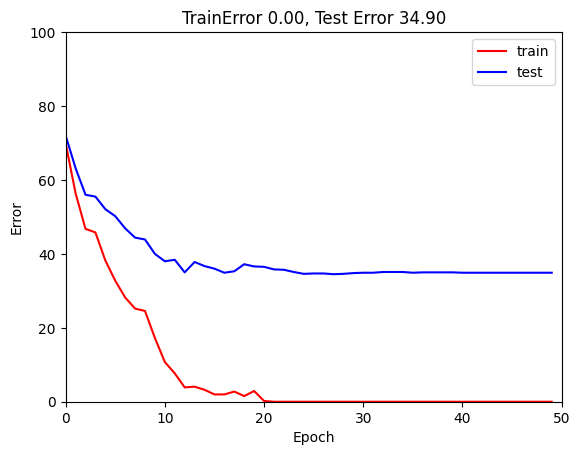

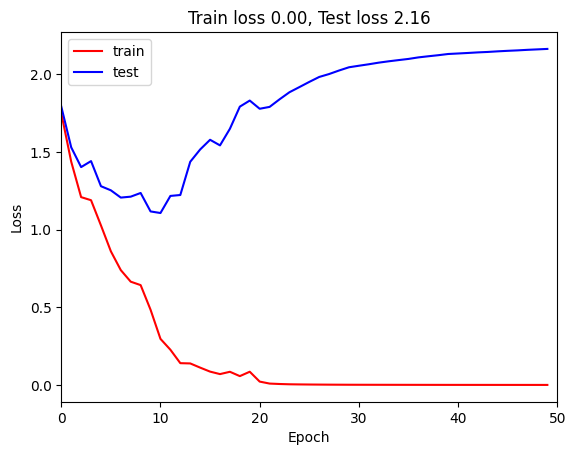

In [15]:
plot_results(errors_train, errors_test, losses_train, losses_test, n_epoch=50)

### Part 1.c)

Let's run one last experiment, this time with a simple linear model with **NO** hidden layers. In this case we will decrease the capacity of the model. Again, pay attention to what happens to the train and test curves.

**TODO:** Define a model with no hidden layers. This model should just be a linear layer that maps from the input dimension, `D_i` to the output dimension, `D_o`

In [16]:
# Define the model with no hidden layers
class LinearModel(nn.Module):
    def __init__(self, D_i=40, D_o=10):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(D_i, D_o)

    def forward(self, x):
        x = self.linear(x)
        return x

# Instantiate the model
model_linear = LinearModel(D_i, D_o)

# Initialize model weights using He initialization
model_linear.apply(weights_init)

LinearModel(
  (linear): Linear(in_features=40, out_features=10, bias=True)
)

**TODO**: Train the model using the same code as above


In [17]:
errors_train, errors_test, losses_train, losses_test = train_model(model_linear, data_loader, n_epoch=50)

Epoch     0, train loss 1.798533, train error 72.22,  test loss 1.818307, test error 74.60
Epoch     1, train loss 1.700973, train error 67.72,  test loss 1.736016, test error 72.30
Epoch     2, train loss 1.659133, train error 65.50,  test loss 1.709015, test error 71.70
Epoch     3, train loss 1.647139, train error 66.10,  test loss 1.695421, test error 70.00
Epoch     4, train loss 1.637474, train error 65.68,  test loss 1.686406, test error 70.50
Epoch     5, train loss 1.632671, train error 64.93,  test loss 1.683353, test error 67.90
Epoch     6, train loss 1.625666, train error 64.85,  test loss 1.669715, test error 68.00
Epoch     7, train loss 1.620194, train error 65.00,  test loss 1.669908, test error 68.30
Epoch     8, train loss 1.633121, train error 65.35,  test loss 1.694953, test error 69.40
Epoch     9, train loss 1.613970, train error 63.28,  test loss 1.675060, test error 70.00
Epoch    10, train loss 1.604139, train error 63.55,  test loss 1.668534, test error 68.00

**TODO**: Plot the results using the same code as above

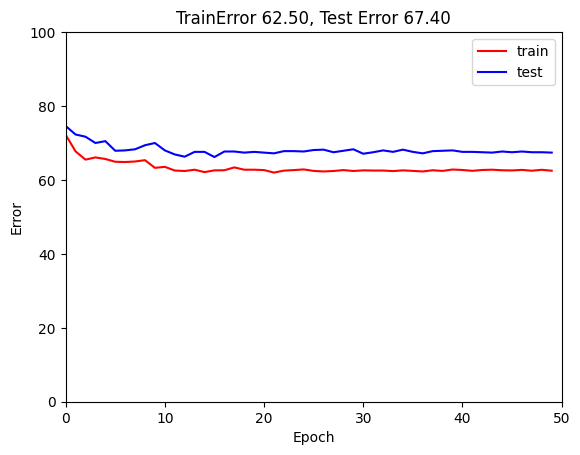

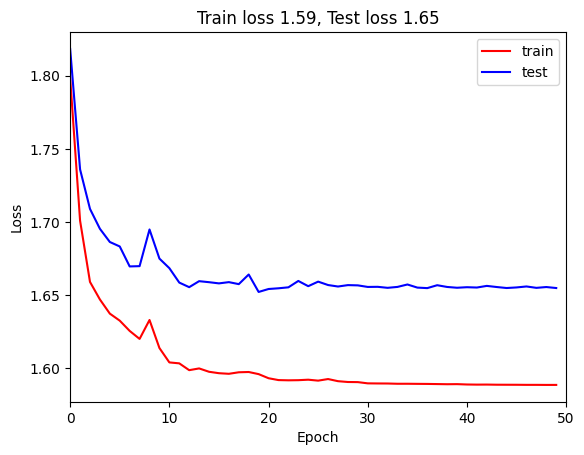

In [18]:
plot_results(errors_train, errors_test, losses_train, losses_test, n_epoch=50)

### Part 1.d: Discussion
What did you observe as you changed the model capacity in your experiments? What are some measures you might include to improve generalization of your models?

I found that altering the model capacity significantly affected test and training results. Training and test errors decreased over epochs using the two hidden layers model, suggesting efficient learning and fair generalization to unknown data. The training error dramatically dropped, frequently nearing zero, when I expanded the capacity to a five hidden layer model, demonstrating how well the model fit the training set. But instead of improving in line, the test error occasionally went up, indicating overfitting—the model was identifying noise and particular, non-generalizing patterns from the training data.

On the other hand, test and training errors peaked at larger values when the capacity was reduced to a linear model devoid of hidden layers. This points to underfitting, in which the model is not sophisticated enough to identify underlying patterns in the data.

## Q2:  Bias-variance Trade-off

In this problem, we will investigate the bias-variance trade-off and reproduce the curves seen in Figure 8.8 in Prince.

In [19]:
import numpy as np
import matplotlib.pyplot as plt

Let's specify the true function that we are trying to estimate, defined on [0,1]

In [20]:
def true_function(x):
    y = np.exp(np.sin(x*(2*3.1413)))
    return y

Now let's generate some data point and add bit of noise to the labels

In [21]:
def generate_data(n_data, sigma_y=0.3):
    # Generate x values quasi uniformly
    x = np.ones(n_data)
    for i in range(n_data):
        x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)

    # y value from running through function and adding noise
    y = np.ones(n_data)
    for i in range(n_data):
        y[i] = true_function(x[i])
        y[i] += np.random.normal(0, sigma_y, 1)
    return x,y

Let's draw the fitted function, together with uncertainty used to generate points


In [22]:
def plot_function(x_func, y_func, x_data=None,y_data=None, x_model = None, y_model =None, sigma_func = None, sigma_model=None):

    fig,ax = plt.subplots()
    ax.plot(x_func, y_func, 'k-')
    if sigma_func is not None:
      ax.fill_between(x_func, y_func-2*sigma_func, y_func+2*sigma_func, color='lightgray')

    if x_data is not None:
        ax.plot(x_data, y_data, 'o', color='#d18362')

    if x_model is not None:
        ax.plot(x_model, y_model, '-', color='#7fe7de')

    if sigma_model is not None:
      ax.fill_between(x_model, y_model-2*sigma_model, y_model+2*sigma_model, color='lightgray')

    ax.set_xlim(0,1)
    ax.set_xlabel('Input, x')
    ax.set_ylabel('Output, y')
    plt.show()
    plt.show()

Sample from the true function (no noise):

In [23]:
x_func = np.linspace(0, 1.0, 100)
y_func = true_function(x_func);

Generate some training data (with noise):

In [24]:
np.random.seed(1)
sigma_func = 0.3
n_data = 15
x_data,y_data = generate_data(n_data, sigma_func)

<ipython-input-21-9b4b2e18b177>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)
<ipython-input-21-9b4b2e18b177>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] += np.random.normal(0, sigma_y, 1)


Plot the data with the functions defined above

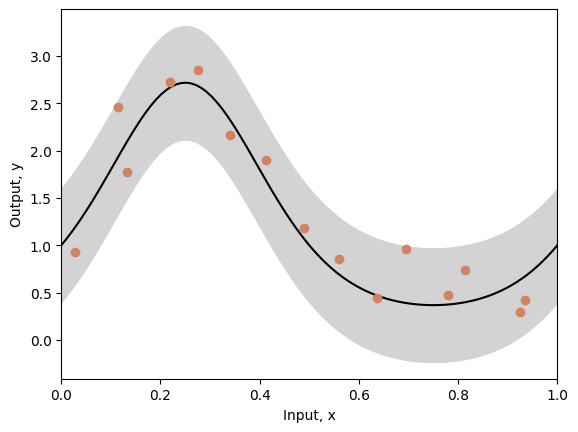

In [25]:
plot_function(x_func, y_func, x_data, y_data, sigma_func=sigma_func)

In [26]:
# Define model -- beta is a scalar and omega has size n_hidden,1
def network(x, beta, omega):
    # Retrieve number of hidden units
    n_hidden = omega.shape[0]

    y = np.zeros_like(x)
    for c_hidden in range(n_hidden):
        # Evaluate activations based on shifted lines (figure 8.4b-d)
        line_vals =  x  - c_hidden/n_hidden
        h =  line_vals * (line_vals > 0)
        # Weight activations by omega parameters and sum
        y = y + omega[c_hidden] * h
    # Add bias, beta
    y = y + beta

    return y

In [27]:
# This fits the n_hidden+1 parameters (see fig 8.4a) in closed form.
# If you have studied linear algebra, then you will know it is a least
# squares solution of the form (A^TA)^-1A^Tb.  If you don't recognize that,
# then just take it on trust that this gives you the best possible solution.
def fit_model_closed_form(x,y,n_hidden):
  n_data = len(x)
  A = np.ones((n_data, n_hidden+1))
  for i in range(n_data):
      for j in range(1,n_hidden+1):
          A[i,j] = x[i]-(j-1)/n_hidden
          if A[i,j] < 0:
              A[i,j] = 0;

  beta_omega = np.linalg.lstsq(A, y, rcond=None)[0]

  beta = beta_omega[0]
  omega = beta_omega[1:]

  return beta, omega

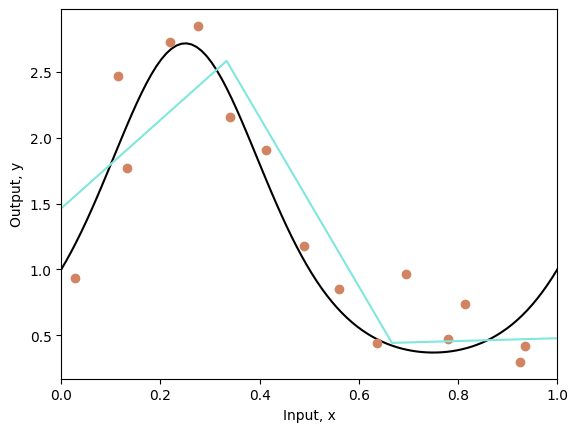

In [28]:
# Closed form solution
beta, omega = fit_model_closed_form(x_data,y_data,n_hidden=3)

# Get prediction for model across graph range
x_model = np.linspace(0,1,100);
y_model = network(x_model, beta, omega)

# Draw the function and the model
plot_function(x_func, y_func, x_data,y_data, x_model, y_model)

### Part 2.a) Estimating the mean and variance of the model outputs, over many training runs

**TODO:** Fill in the missing pieces of this function to tun the model many times with different datasets and return the mean and variance


In [29]:
def get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func):
    # Create array that stores model results in rows
    y_model_all = np.zeros((n_datasets, n_data))
    x_model = np.linspace(-1, 1, n_data)

    for c_dataset in range(n_datasets):
        # Generate n_data x,y pairs with standard deviation sigma_func
        x_data = np.linspace(-1, 1, n_data)

        # Check if sigma_func is callable; if not, assume it's a constant
        if callable(sigma_func):
            sigma = sigma_func(x_data)
        else:
            sigma = sigma_func

        # Generate noise with standard deviation sigma
        noise = np.random.normal(0, sigma, size=n_data)
        y_data = x_data ** 3 + noise  # True function plus noise

        # Convert data to tensors
        x_tensor = torch.tensor(x_data, dtype=torch.float32).unsqueeze(1)
        y_tensor = torch.tensor(y_data, dtype=torch.float32).unsqueeze(1)

        # Fit the model
        class SimpleNet(nn.Module):
            def __init__(self, n_hidden):
                super(SimpleNet, self).__init__()
                self.fc1 = nn.Linear(1, n_hidden)
                self.relu = nn.ReLU()
                self.fc2 = nn.Linear(n_hidden, 1)

            def forward(self, x):
                x = self.relu(self.fc1(x))
                x = self.fc2(x)
                return x

        # Initialize the model
        model = SimpleNet(n_hidden)

        # Define loss function and optimizer
        loss_function = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

        # Train the model
        num_epochs = 1000
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(x_tensor)
            loss = loss_function(outputs, y_tensor)
            loss.backward()
            optimizer.step()

        # Run the fitted model on x_model
        model.eval()
        with torch.no_grad():
            x_model_tensor = torch.tensor(x_model, dtype=torch.float32).unsqueeze(1)
            y_model = model(x_model_tensor).numpy().flatten()

        # Store the model results
        y_model_all[c_dataset, :] = y_model

    # Get mean and standard deviation of the model predictions
    mean_model = np.mean(y_model_all, axis=0)
    std_model = np.std(y_model_all, axis=0)

    # Return the mean and standard deviation of the fitted model
    return mean_model, std_model

Let's generate N=100 random data sets, fit the model N=100 times and look the mean and variance. Here we will have 15 data points and 3 hidden units in our model:

In [30]:
n_datasets = 100
n_data = 15
sigma_func = 0.3
n_hidden = 3

# Get mean and variance of fitted model
np.random.seed(1)
mean_model, std_model = get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func)

Plot the results


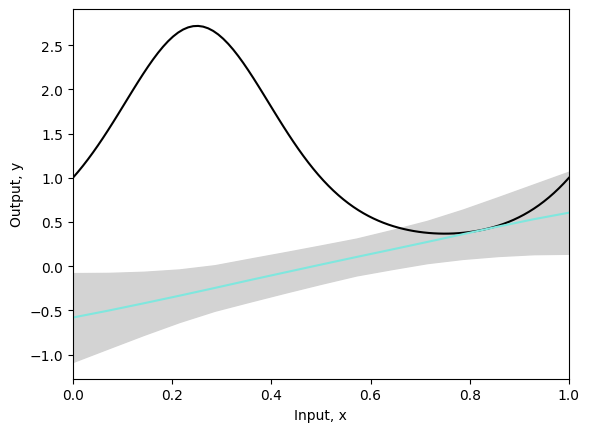

In [31]:
x_model_grid = np.linspace(0, 1, len(mean_model))
plot_function(x_func, y_func, x_model=x_model_grid, y_model=mean_model, sigma_model=std_model)

If you did this correctly, you can see that there that we observe both **bias** and **variance** in the model outputs. Here bias refers to the fact that we have some error from the model outputs and the true function (distance between cyan and black lines); variance refers to the gray region indicating there is a fair amount of variability in what the model outputs over each dataset it sees.


### Part 2.b) Changing the amount of available data

**TODO**: Let's rerun the same experiment as the cell above, but this time let's increase the the number of training points to 100, `n_data=100`

In [32]:
n_datasets = 100
n_data = 100
sigma_func = 0.3
n_hidden = 3

# Get mean and variance of fitted model
np.random.seed(1)
mean_model, std_model = get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func)

**TODO**: Plot the results:

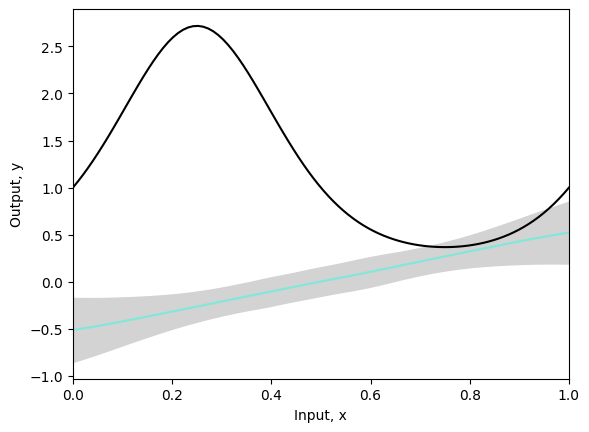

In [33]:
x_model_grid = np.linspace(0, 1, len(mean_model))
plot_function(x_func, y_func, x_model=x_model_grid, y_model=mean_model, sigma_model=std_model)

**TODO**: What happened to the variance? Record your observations

I found that the variance of the model outputs across various datasets significantly decreased when the number of training points was increased to 100 (n_data = 100). More training data gave each model access to a fuller representation of the underlying function y = x^3, which improved learning accuracy. As a result, the models generated predictions that were closer to the actual function and more consistent with one another.

The gray area in the charts that shows the model outputs' variability (variance) grew noticeably smaller. This shows that at every location along the x-axis, the standard deviation of the models' predictions dropped. Because the effect of any single noisy observation was diffused by the increased number of data points, the models were less affected by the random noise seen in each dataset.

The reason for the decrease in variance is that the models have grown more resilient to the variations brought on by noise in the training set. Rather than overfitting to the noise present in smaller datasets, the models might more accurately represent the genuine underlying patterns with more data points. This is consistent with the machine learning trade-off between bias and variance: a larger dataset tends to decrease variance without necessarily increasing bias.

### Part 2.c) Increasing the model capacity

**TODO**: Let's rerun the same experiment as the cell above, but this time let's increase set the number of hidden units to 12 and the number of training points to 15

In [34]:
n_datasets = 100
n_data = 15
sigma_func = 0.3
n_hidden = 12

# Get mean and variance of fitted model
np.random.seed(1)
mean_model, std_model = get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func)

**TODO**: Plot the results

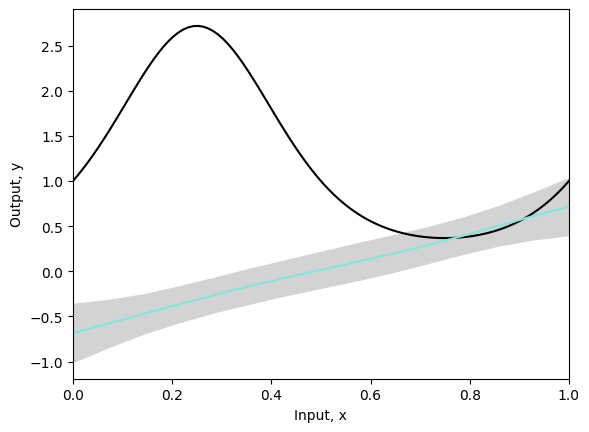

In [35]:
x_model_grid = np.linspace(0, 1, len(mean_model))
plot_function(x_func, y_func, x_model=x_model_grid, y_model=mean_model, sigma_model=std_model)

**TODO**: What happened to the bias? Record your observations

After conducting the experiment again with 12 hidden units (n_hidden = 12) and 15 training points (n_data = 15), I found that the model outputs had a considerable increase in bias. The term "bias" describes the discrepancy between the true function y=x^3 and the average prediction made by our models. This is visible in the context of our graphs as the separation between the true function (black line) and the mean model prediction (often represented as a cyan or blue line).

The models lacked sufficient data to adequately represent the intricacy of the true function, with only 15 training points. The lack of data hindered the models' ability to efficiently identify the underlying patterns, even though the number of hidden units enhanced the model's capacity. Due to the models' poor generalization abilities, predictions over the input range strayed further from the true function.

The mean model predictions' consistent deviation from the true function indicates this growing bias. With such little data, the models were unable to correctly identify the cubic relationship, which led to an underfitting of the data. The models may have fit the noise in the limited datasets rather than the genuine underlying trend as a result of the larger capacity (more hidden units), which could not make up for the lack of data.

To summarize, the models' average predictions deviated more from the true function when the number of training points was reduced to 15. This resulted in an increase in bias. The true link between x and y could not be effectively captured by the models due to a combination of inadequate data and increased model complexity. This experiment emphasizes how crucial it is to have an adequate amount of training data in order to minimize bias and guarantee that models are able to recognize and extrapolate the real patterns found in the data.

### Part 2.d) High capacity and high data

**TODO**: Let's rerun the same experiment as the cell above, but this time let's increase set the number of hidden units to 12 and the number of training points to 1000

In [36]:
n_datasets = 100
n_data = 1000
sigma_func = 0.3
n_hidden = 12

# Get mean and variance of fitted model
np.random.seed(1)
mean_model, std_model = get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func)

**TODO:** Plot the results

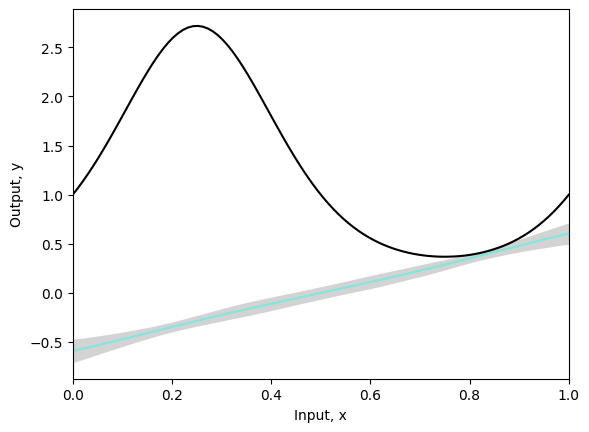

In [37]:
x_model_grid = np.linspace(0, 1, len(mean_model))
plot_function(x_func, y_func, x_model=x_model_grid, y_model=mean_model, sigma_model=std_model)

**TODO**: Record your observations about the bias and variance in this setting

I saw a considerable decrease in bias and variance in the model outputs when I reran the experiment with 12 hidden units (n_hidden = 12) and increased the number of training points to 1000 (n_data = 1000). A higher number of hidden units improved the model's ability to learn intricate patterns and better represent the true underlying function, which is y=x^3. The mean model forecast closely matches the true function over the whole range of x, indicating a reduction in bias.

In addition, the significant increase in training data gave the model a richer dataset from which to learn, allowing it to cover the input space more completely. Because there was an abundance of data, the model's predictions were less susceptible to the random fluctuations seen in other datasets, which reduced variance. A smaller standard deviation around the mean prediction was obtained as a result of a decrease in variability among models trained on various datasets.

The charts show that the models are accurately learning the genuine connection when the difference between the mean model prediction and the true function (bias) becomes small. Additionally, the shaded region representing the variance, or standard deviation, shrank dramatically, indicating that the models' predictions held true across several training sets.

In this configuration, the model has enough capacity and data to train efficiently—an ideal state of affairs. The huge dataset lowers variance by guaranteeing stability and consistency in the model's learning process, while the high capacity decreases bias by enabling the model to fit the true function closely.

## Q3) High Dimensional Spaces
This question investigates the strange properties of high-dimensional spaces as discussed in the notes at the end of chapter 8.



In [38]:
from scipy.spatial.distance import pdist

In [39]:
# Fix the random seed so we all have the same random numbers
np.random.seed(0)
n_data = 1000
# Create 1000 data examples (columns) each with 2 dimensions (rows)
n_dim = 2
x_2D = np.random.normal(size=(n_dim,n_data))
# Create 1000 data examples (columns) each with 100 dimensions (rows)
n_dim = 100
x_100D = np.random.normal(size=(n_dim,n_data))
# Create 1000 data examples (columns) each with 1000 dimensions (rows)
n_dim = 1000
x_1000D = np.random.normal(size=(n_dim,n_data))

**TODO:** Implement the missing parts of the function below:

In [40]:
import numpy as np
from scipy.spatial.distance import pdist

def distance_ratio(x):
    # Calculate the largest and smallest Euclidean distances between
    # the data points in the columns of x. DO NOT include the distance between
    # the data point and itself (which is obviously zero)

    # Transpose x to have data points as rows
    x_T = x.T  # Now each row is a data point

    # Compute all pairwise Euclidean distances between data points
    distances = pdist(x_T, metric='euclidean')

    # Exclude zero distances (in case of duplicate points)
    nonzero_distances = distances[distances > 0]

    # Calculate the smallest and largest distances
    smallest_dist = np.min(nonzero_distances)
    largest_dist = np.max(nonzero_distances)

    # Calculate the ratio and return
    dist_ratio = largest_dist / smallest_dist
    return dist_ratio

In [41]:

print('Ratio of largest to smallest distance 2D: %3.3f'%(distance_ratio(x_2D)))
print('Ratio of largest to smallest distance 100D: %3.3f'%(distance_ratio(x_100D)))
print('Ratio of largest to smallest distance 1000D: %3.3f'%(distance_ratio(x_1000D)))


Ratio of largest to smallest distance 2D: 2840.258
Ratio of largest to smallest distance 100D: 2.038
Ratio of largest to smallest distance 1000D: 1.221


If you did this right, you will see that the distance between the nearest and farthest two points in high dimensions is almost the same.

